In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os


import Libraries.dataloader as dl
import segmentation_models_pytorch as smp

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

from Libraries.unet3d import UNet
from Libraries.dataloader import DataLoader

import os
from PIL import Image
from IPython.display import display
import open3d as o3d

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Functions 
def CreatePointCloud(color_im, depth_im):
    color_raw = o3d.geometry.Image(np.uint8(color_im))
    depth_raw = o3d.geometry.Image(np.float32(depth_im))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, 1000) # 
    PointCloud = o3d.geometry.PointCloud.create_from_rgbd_image(
      rgbd_image,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)) # Creates Point Cloud from rgbd image
#     PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def CreateAxisCloud(depth_im):
    depth_raw  = o3d.geometry.Image(np.float32(depth_im/1)) # Converts depth data into image format
    PointCloud = o3d.geometry.PointCloud.create_from_depth_image(depth_raw,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    # PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def pick_points(pcd):
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()
    numpy_array=np.asarray(pcd.points)
    point_id=vis.get_picked_points()

    return [numpy_array[point_id[0]],numpy_array[point_id[1]]]

def draw_arrow(pcd, points_real, points_extimated):
    lines=[[0,1],[2,3]]
    points = np.concatenate((points_real, points_extimated), axis=0)
    colors = [[1,0,0],[0,1,0]] # Red is REAL and Green is ESTIMATED
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),

    )
    line_set.colors=o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd,line_set])

In [4]:
# Transformations

class GaussianNoise(object):
    def __init__(self, p=0.5, mean=[0.0, 0.5], std=[1.0, 1.0]):
        self.p    = p
        self.std  = np.random.uniform(std[0],std[1])
        self.mean = np.random.uniform(mean[0],mean[1])
        
    def __call__(self, tensor):
        if random.random() < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            return tensor 


DataAug = transforms.Compose([
    transforms.ColorJitter(
        brightness=[0.5,1.5],
        contrast=[0.5, 1.5],
        saturation=[0.5, 1.5],
        hue=[-0.1,0.1],
    ),
    transforms.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 9.0)
    ),
#     transforms.RandomErasing(
#         p=0.1,
#         scale=(0.01, 0.1),
#         ratio=(0.01, 3.3),
#         value=0,
#     ),
    GaussianNoise(
        p=0.2,
        mean=[0.0, 0.1],
        std=[0.01, 0.3]
    )
])

In [7]:
DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
dl = DataLoader()
RGBD_in,axis_out = dl.load(DATASET_ROOTDIR, 'files/data.csv', 'S')

In [8]:
X_train, X_validation, y_train, y_validation = train_test_split(RGBD_in, axis_out, test_size=0.2)

X_train_aug = X_train.clone()
for i in range(X_train_aug.shape[0]):
     X_train_aug[i] = DataAug(X_train_aug[i])
        
y_train = torch.cat((y_train, y_train),axis=0)
X_train = torch.cat((X_train, X_train_aug),axis=0)

print(y_train.shape)
print(X_train.shape)

torch.Size([248, 1, 256, 320])
torch.Size([248, 3, 256, 320])


In [7]:
train_set = TensorDataset(X_train, y_train)
val_set = TensorDataset(X_validation, y_validation)

loader_args = dict(batch_size=2, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
train_loader = DataLoader(train_set,shuffle=True, **loader_args)
val_loader = DataLoader(val_set,shuffle=False, **loader_args)

In [8]:
device='cuda'
Model= smp.Unet(in_channels=3, classes=1,encoder_weights=None,encoder_name='timm-resnest50d').to(device)
Model.load_state_dict(torch.load('Modele/UN1-A_80E_DL.pt'))
Model.eval()

Unet(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [9]:
ModelCutter = smp.Unet(in_channels=4, classes=1, encoder_weights=None, encoder_name='timm-resnest50d').to(device)
# ModelCutter = UNet(n_channels=4, n_classes=1, width_multiplier=1, trilinear=True, use_ds_conv=False).to(device)

In [10]:
class InpaintLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, out, gt, mask):
        out = torch.mul(out, mask.view(out.shape))
        mask = torch.nonzero(mask.reshape(-1))
        
        loss = torch.sum(torch.abs(torch.subtract(out, gt)).view(-1))
        loss = torch.div(loss, mask.shape[0])

        return loss

In [11]:
criterion = nn.MSELoss()
# criterion = InpaintLoss()

optimizer = torch.optim.Adam(ModelCutter.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10) 

In [12]:
epochs = 80

train_losses = []
validation_losses = []

ModelCutter.train()

for epoch in range(epochs):
    for batch, (images, true_mask) in enumerate(train_loader):
        
        batch+=1
        new_conn = []
    #         Apply the model
        images = images.to(device=device)
        true_mask = true_mask.to(device=device)
        
        with torch.no_grad():
            seg_ax = Model(images) 
            seg_ax = F.threshold(seg_ax, 1, 0)
  
        images_connected = torch.cat((images, seg_ax), axis=1)
#         images_connected = images_connected.reshape(images_connected.shape[0],
#                                                     4, 64, 80, 16) # transofrmation for UNet3D
#         true_mask = true_mask.reshape(true_mask.shape[0],
#                                                     1, 64, 80, 16) # transofrmation for UNet3D
        mask_pred = ModelCutter(images_connected)
        loss = criterion(mask_pred,true_mask)     
#         loss = criterion(mask_pred,true_mask,seg_ax)

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        print(f'epoch: {epoch+1:2}  batch: {batch}  loss: {loss.item():10.8f}')

    train_losses.append(loss.cpu().detach().numpy())
    scheduler.step(loss)
# Run the validationing batches
    with torch.no_grad():
        for batch, (images, true_mask) in enumerate(val_loader):
            batch+=1
            
            images = images.to(device=device)
            true_mask = true_mask.to(device=device)

            with torch.no_grad():
                seg_ax = Model(images)
                seg_ax = F.threshold(seg_ax, 1, 0)
            
            images_connected = torch.cat((images, seg_ax), axis=1)
#             images_connected = images_connected.reshape(images_connected.shape[0],
#                                                     4, 64, 80, 16) # transofrmation for UNet3D
#             true_mask = true_mask.reshape(true_mask.shape[0],
#                                                     1, 64, 80, 16) # transofrmation for UNet3D
            
            mask_pred = ModelCutter(images_connected)
            loss = criterion(mask_pred,true_mask)  
#             loss = criterion(mask_pred,true_mask,seg_ax)

    validation_losses.append(loss.cpu().detach().numpy())

epoch:  1  batch: 1  loss: 1.33119810
epoch:  1  batch: 2  loss: 0.79925770
epoch:  1  batch: 3  loss: 0.31823468
epoch:  1  batch: 4  loss: 0.16421413
epoch:  1  batch: 5  loss: 0.11378098
epoch:  1  batch: 6  loss: 0.07393062
epoch:  1  batch: 7  loss: 0.05554595
epoch:  1  batch: 8  loss: 0.04577736
epoch:  1  batch: 9  loss: 0.04217905
epoch:  1  batch: 10  loss: 0.02873512
epoch:  1  batch: 11  loss: 0.02433437
epoch:  1  batch: 12  loss: 0.03127015
epoch:  1  batch: 13  loss: 0.01700681
epoch:  1  batch: 14  loss: 0.02122605
epoch:  1  batch: 15  loss: 0.03177286
epoch:  1  batch: 16  loss: 0.02339998
epoch:  1  batch: 17  loss: 0.01942718
epoch:  1  batch: 18  loss: 0.01250615
epoch:  1  batch: 19  loss: 0.04202903
epoch:  1  batch: 20  loss: 0.01377581
epoch:  1  batch: 21  loss: 0.06350536
epoch:  1  batch: 22  loss: 0.03793116
epoch:  1  batch: 23  loss: 0.01479554
epoch:  1  batch: 24  loss: 0.01841802
epoch:  1  batch: 25  loss: 0.01275657
epoch:  1  batch: 26  loss: 0.0100

epoch:  2  batch: 88  loss: 0.00403104
epoch:  2  batch: 89  loss: 0.01639965
epoch:  2  batch: 90  loss: 0.00409292
epoch:  2  batch: 91  loss: 0.00496339
epoch:  2  batch: 92  loss: 0.00525023
epoch:  2  batch: 93  loss: 0.00809595
epoch:  2  batch: 94  loss: 0.01121129
epoch:  2  batch: 95  loss: 0.00773562
epoch:  2  batch: 96  loss: 0.00559014
epoch:  2  batch: 97  loss: 0.00348034
epoch:  2  batch: 98  loss: 0.00569677
epoch:  2  batch: 99  loss: 0.00780001
epoch:  2  batch: 100  loss: 0.00920331
epoch:  2  batch: 101  loss: 0.01196093
epoch:  2  batch: 102  loss: 0.02334094
epoch:  2  batch: 103  loss: 0.00474150
epoch:  2  batch: 104  loss: 0.00928486
epoch:  2  batch: 105  loss: 0.00888472
epoch:  2  batch: 106  loss: 0.01364971
epoch:  2  batch: 107  loss: 0.01666420
epoch:  2  batch: 108  loss: 0.01413442
epoch:  2  batch: 109  loss: 0.00795096
epoch:  2  batch: 110  loss: 0.00507668
epoch:  2  batch: 111  loss: 0.00587959
epoch:  2  batch: 112  loss: 0.03381234
epoch:  2  b

epoch:  4  batch: 52  loss: 0.01345437
epoch:  4  batch: 53  loss: 0.00760214
epoch:  4  batch: 54  loss: 0.02040786
epoch:  4  batch: 55  loss: 0.00774255
epoch:  4  batch: 56  loss: 0.01570727
epoch:  4  batch: 57  loss: 0.00320873
epoch:  4  batch: 58  loss: 0.01099727
epoch:  4  batch: 59  loss: 0.01513802
epoch:  4  batch: 60  loss: 0.01290927
epoch:  4  batch: 61  loss: 0.00717729
epoch:  4  batch: 62  loss: 0.00472397
epoch:  4  batch: 63  loss: 0.03101398
epoch:  4  batch: 64  loss: 0.00367599
epoch:  4  batch: 65  loss: 0.00684357
epoch:  4  batch: 66  loss: 0.02860621
epoch:  4  batch: 67  loss: 0.00273621
epoch:  4  batch: 68  loss: 0.00704820
epoch:  4  batch: 69  loss: 0.15624981
epoch:  4  batch: 70  loss: 0.07063677
epoch:  4  batch: 71  loss: 0.00393579
epoch:  4  batch: 72  loss: 0.00599442
epoch:  4  batch: 73  loss: 0.00334929
epoch:  4  batch: 74  loss: 0.00383148
epoch:  4  batch: 75  loss: 0.00432862
epoch:  4  batch: 76  loss: 0.02047315
epoch:  4  batch: 77  los

epoch:  6  batch: 16  loss: 0.00868953
epoch:  6  batch: 17  loss: 0.02745687
epoch:  6  batch: 18  loss: 0.00290028
epoch:  6  batch: 19  loss: 0.00850420
epoch:  6  batch: 20  loss: 0.00748036
epoch:  6  batch: 21  loss: 0.00890474
epoch:  6  batch: 22  loss: 0.01080442
epoch:  6  batch: 23  loss: 0.01886836
epoch:  6  batch: 24  loss: 0.00687236
epoch:  6  batch: 25  loss: 0.03078035
epoch:  6  batch: 26  loss: 0.03570206
epoch:  6  batch: 27  loss: 0.00532567
epoch:  6  batch: 28  loss: 0.00451487
epoch:  6  batch: 29  loss: 0.00412253
epoch:  6  batch: 30  loss: 0.00651928
epoch:  6  batch: 31  loss: 0.02189659
epoch:  6  batch: 32  loss: 0.00583719
epoch:  6  batch: 33  loss: 0.03743458
epoch:  6  batch: 34  loss: 0.00602444
epoch:  6  batch: 35  loss: 0.01000598
epoch:  6  batch: 36  loss: 0.00803030
epoch:  6  batch: 37  loss: 0.00537208
epoch:  6  batch: 38  loss: 0.00766710
epoch:  6  batch: 39  loss: 0.00359860
epoch:  6  batch: 40  loss: 0.00312901
epoch:  6  batch: 41  los

epoch:  7  batch: 103  loss: 0.00295916
epoch:  7  batch: 104  loss: 0.00638232
epoch:  7  batch: 105  loss: 0.00975652
epoch:  7  batch: 106  loss: 0.01041383
epoch:  7  batch: 107  loss: 0.06396424
epoch:  7  batch: 108  loss: 0.00480743
epoch:  7  batch: 109  loss: 0.02447278
epoch:  7  batch: 110  loss: 0.00877809
epoch:  7  batch: 111  loss: 0.01075628
epoch:  7  batch: 112  loss: 0.00441281
epoch:  7  batch: 113  loss: 0.00224302
epoch:  7  batch: 114  loss: 0.00283263
epoch:  7  batch: 115  loss: 0.00661643
epoch:  7  batch: 116  loss: 0.00835765
epoch:  7  batch: 117  loss: 0.01052303
epoch:  7  batch: 118  loss: 0.00616954
epoch:  7  batch: 119  loss: 0.01083496
epoch:  7  batch: 120  loss: 0.00566154
epoch:  7  batch: 121  loss: 0.00499340
epoch:  7  batch: 122  loss: 0.00478018
epoch:  7  batch: 123  loss: 0.03667265
epoch:  7  batch: 124  loss: 0.01178499
epoch:  8  batch: 1  loss: 0.00593051
epoch:  8  batch: 2  loss: 0.00894996
epoch:  8  batch: 3  loss: 0.00172306
epoch:

epoch:  9  batch: 67  loss: 0.00685427
epoch:  9  batch: 68  loss: 0.03829509
epoch:  9  batch: 69  loss: 0.00187087
epoch:  9  batch: 70  loss: 0.03033309
epoch:  9  batch: 71  loss: 0.00805912
epoch:  9  batch: 72  loss: 0.01968945
epoch:  9  batch: 73  loss: 0.00670526
epoch:  9  batch: 74  loss: 0.00761755
epoch:  9  batch: 75  loss: 0.00867877
epoch:  9  batch: 76  loss: 0.04939167
epoch:  9  batch: 77  loss: 0.00345586
epoch:  9  batch: 78  loss: 0.00527678
epoch:  9  batch: 79  loss: 0.00275614
epoch:  9  batch: 80  loss: 0.01379784
epoch:  9  batch: 81  loss: 0.00597520
epoch:  9  batch: 82  loss: 0.00936006
epoch:  9  batch: 83  loss: 0.00429476
epoch:  9  batch: 84  loss: 0.00754394
epoch:  9  batch: 85  loss: 0.00351614
epoch:  9  batch: 86  loss: 0.00344798
epoch:  9  batch: 87  loss: 0.01127314
epoch:  9  batch: 88  loss: 0.00356099
epoch:  9  batch: 89  loss: 0.00788196
epoch:  9  batch: 90  loss: 0.02466283
epoch:  9  batch: 91  loss: 0.00357666
epoch:  9  batch: 92  los

epoch: 11  batch: 29  loss: 0.00855860
epoch: 11  batch: 30  loss: 0.00314344
epoch: 11  batch: 31  loss: 0.01056353
epoch: 11  batch: 32  loss: 0.00409215
epoch: 11  batch: 33  loss: 0.00609334
epoch: 11  batch: 34  loss: 0.04618239
epoch: 11  batch: 35  loss: 0.00317021
epoch: 11  batch: 36  loss: 0.00772669
epoch: 11  batch: 37  loss: 0.00126793
epoch: 11  batch: 38  loss: 0.00790398
epoch: 11  batch: 39  loss: 0.00202103
epoch: 11  batch: 40  loss: 0.01089650
epoch: 11  batch: 41  loss: 0.07691902
epoch: 11  batch: 42  loss: 0.00816437
epoch: 11  batch: 43  loss: 0.00709863
epoch: 11  batch: 44  loss: 0.01147602
epoch: 11  batch: 45  loss: 0.00400082
epoch: 11  batch: 46  loss: 0.00583453
epoch: 11  batch: 47  loss: 0.00488492
epoch: 11  batch: 48  loss: 0.00878703
epoch: 11  batch: 49  loss: 0.00538459
epoch: 11  batch: 50  loss: 0.00891879
epoch: 11  batch: 51  loss: 0.02433197
epoch: 11  batch: 52  loss: 0.00892712
epoch: 11  batch: 53  loss: 0.00242793
epoch: 11  batch: 54  los

epoch: 12  batch: 116  loss: 0.00691759
epoch: 12  batch: 117  loss: 0.00455933
epoch: 12  batch: 118  loss: 0.00795510
epoch: 12  batch: 119  loss: 0.00279016
epoch: 12  batch: 120  loss: 0.01920270
epoch: 12  batch: 121  loss: 0.00776868
epoch: 12  batch: 122  loss: 0.00893283
epoch: 12  batch: 123  loss: 0.00644349
epoch: 12  batch: 124  loss: 0.02690094
epoch: 13  batch: 1  loss: 0.00173340
epoch: 13  batch: 2  loss: 0.00425739
epoch: 13  batch: 3  loss: 0.00929870
epoch: 13  batch: 4  loss: 0.00388705
epoch: 13  batch: 5  loss: 0.00373453
epoch: 13  batch: 6  loss: 0.01935838
epoch: 13  batch: 7  loss: 0.00831021
epoch: 13  batch: 8  loss: 0.00327768
epoch: 13  batch: 9  loss: 0.00104151
epoch: 13  batch: 10  loss: 0.00728036
epoch: 13  batch: 11  loss: 0.01851891
epoch: 13  batch: 12  loss: 0.01039612
epoch: 13  batch: 13  loss: 0.00102438
epoch: 13  batch: 14  loss: 0.02703977
epoch: 13  batch: 15  loss: 0.07894333
epoch: 13  batch: 16  loss: 0.00917583
epoch: 13  batch: 17  los

epoch: 14  batch: 79  loss: 0.00652185
epoch: 14  batch: 80  loss: 0.01679055
epoch: 14  batch: 81  loss: 0.01666969
epoch: 14  batch: 82  loss: 0.00776787
epoch: 14  batch: 83  loss: 0.00433506
epoch: 14  batch: 84  loss: 0.00985340
epoch: 14  batch: 85  loss: 0.00179262
epoch: 14  batch: 86  loss: 0.02177119
epoch: 14  batch: 87  loss: 0.00340389
epoch: 14  batch: 88  loss: 0.00481705
epoch: 14  batch: 89  loss: 0.00629256
epoch: 14  batch: 90  loss: 0.00790280
epoch: 14  batch: 91  loss: 0.00688265
epoch: 14  batch: 92  loss: 0.06338000
epoch: 14  batch: 93  loss: 0.01449290
epoch: 14  batch: 94  loss: 0.00733111
epoch: 14  batch: 95  loss: 0.00394455
epoch: 14  batch: 96  loss: 0.00244120
epoch: 14  batch: 97  loss: 0.00778407
epoch: 14  batch: 98  loss: 0.00383191
epoch: 14  batch: 99  loss: 0.00117243
epoch: 14  batch: 100  loss: 0.00680220
epoch: 14  batch: 101  loss: 0.00887196
epoch: 14  batch: 102  loss: 0.00461922
epoch: 14  batch: 103  loss: 0.00421890
epoch: 14  batch: 104

epoch: 16  batch: 41  loss: 0.00702697
epoch: 16  batch: 42  loss: 0.00856693
epoch: 16  batch: 43  loss: 0.03300301
epoch: 16  batch: 44  loss: 0.00617034
epoch: 16  batch: 45  loss: 0.00308654
epoch: 16  batch: 46  loss: 0.01877063
epoch: 16  batch: 47  loss: 0.00410075
epoch: 16  batch: 48  loss: 0.01279504
epoch: 16  batch: 49  loss: 0.00158855
epoch: 16  batch: 50  loss: 0.01165838
epoch: 16  batch: 51  loss: 0.00228042
epoch: 16  batch: 52  loss: 0.04009403
epoch: 16  batch: 53  loss: 0.00465678
epoch: 16  batch: 54  loss: 0.00357041
epoch: 16  batch: 55  loss: 0.00346606
epoch: 16  batch: 56  loss: 0.01505930
epoch: 16  batch: 57  loss: 0.01916543
epoch: 16  batch: 58  loss: 0.00331660
epoch: 16  batch: 59  loss: 0.00926242
epoch: 16  batch: 60  loss: 0.01232189
epoch: 16  batch: 61  loss: 0.00468888
epoch: 16  batch: 62  loss: 0.00449993
epoch: 16  batch: 63  loss: 0.01132245
epoch: 16  batch: 64  loss: 0.00885740
epoch: 16  batch: 65  loss: 0.02256398
epoch: 16  batch: 66  los

epoch: 18  batch: 4  loss: 0.00162732
epoch: 18  batch: 5  loss: 0.03918156
epoch: 18  batch: 6  loss: 0.00276032
epoch: 18  batch: 7  loss: 0.02517599
epoch: 18  batch: 8  loss: 0.00824712
epoch: 18  batch: 9  loss: 0.00313208
epoch: 18  batch: 10  loss: 0.00373049
epoch: 18  batch: 11  loss: 0.00217262
epoch: 18  batch: 12  loss: 0.00441965
epoch: 18  batch: 13  loss: 0.00306227
epoch: 18  batch: 14  loss: 0.00475701
epoch: 18  batch: 15  loss: 0.03313017
epoch: 18  batch: 16  loss: 0.01430706
epoch: 18  batch: 17  loss: 0.00232070
epoch: 18  batch: 18  loss: 0.00495600
epoch: 18  batch: 19  loss: 0.01311245
epoch: 18  batch: 20  loss: 0.00490652
epoch: 18  batch: 21  loss: 0.00406310
epoch: 18  batch: 22  loss: 0.00734929
epoch: 18  batch: 23  loss: 0.00181386
epoch: 18  batch: 24  loss: 0.09569831
epoch: 18  batch: 25  loss: 0.00170067
epoch: 18  batch: 26  loss: 0.00412887
epoch: 18  batch: 27  loss: 0.00345352
epoch: 18  batch: 28  loss: 0.00635351
epoch: 18  batch: 29  loss: 0.0

epoch: 19  batch: 90  loss: 0.00276434
epoch: 19  batch: 91  loss: 0.02280413
epoch: 19  batch: 92  loss: 0.00063531
epoch: 19  batch: 93  loss: 0.01754434
epoch: 19  batch: 94  loss: 0.00718334
epoch: 19  batch: 95  loss: 0.00554761
epoch: 19  batch: 96  loss: 0.00655614
epoch: 19  batch: 97  loss: 0.00278658
epoch: 19  batch: 98  loss: 0.00087983
epoch: 19  batch: 99  loss: 0.03593722
epoch: 19  batch: 100  loss: 0.00793135
epoch: 19  batch: 101  loss: 0.00162791
epoch: 19  batch: 102  loss: 0.00224827
epoch: 19  batch: 103  loss: 0.00715545
epoch: 19  batch: 104  loss: 0.00340453
epoch: 19  batch: 105  loss: 0.00949319
epoch: 19  batch: 106  loss: 0.00788292
epoch: 19  batch: 107  loss: 0.01026429
epoch: 19  batch: 108  loss: 0.00163773
epoch: 19  batch: 109  loss: 0.00113048
epoch: 19  batch: 110  loss: 0.00551141
epoch: 19  batch: 111  loss: 0.01083247
epoch: 19  batch: 112  loss: 0.00379974
epoch: 19  batch: 113  loss: 0.05487058
epoch: 19  batch: 114  loss: 0.00171222
epoch: 19 

epoch: 21  batch: 52  loss: 0.00188066
epoch: 21  batch: 53  loss: 0.00399564
epoch: 21  batch: 54  loss: 0.01209287
epoch: 21  batch: 55  loss: 0.00299263
epoch: 21  batch: 56  loss: 0.00454551
epoch: 21  batch: 57  loss: 0.00217641
epoch: 21  batch: 58  loss: 0.00495532
epoch: 21  batch: 59  loss: 0.00329095
epoch: 21  batch: 60  loss: 0.00534853
epoch: 21  batch: 61  loss: 0.00952475
epoch: 21  batch: 62  loss: 0.01071457
epoch: 21  batch: 63  loss: 0.00837630
epoch: 21  batch: 64  loss: 0.00543638
epoch: 21  batch: 65  loss: 0.00384362
epoch: 21  batch: 66  loss: 0.00426886
epoch: 21  batch: 67  loss: 0.00139907
epoch: 21  batch: 68  loss: 0.00259602
epoch: 21  batch: 69  loss: 0.00590635
epoch: 21  batch: 70  loss: 0.00331277
epoch: 21  batch: 71  loss: 0.00279165
epoch: 21  batch: 72  loss: 0.00166533
epoch: 21  batch: 73  loss: 0.00272869
epoch: 21  batch: 74  loss: 0.00715189
epoch: 21  batch: 75  loss: 0.03778362
epoch: 21  batch: 76  loss: 0.03448837
epoch: 21  batch: 77  los

epoch: 23  batch: 14  loss: 0.00835551
epoch: 23  batch: 15  loss: 0.01908181
epoch: 23  batch: 16  loss: 0.00295516
epoch: 23  batch: 17  loss: 0.00110848
epoch: 23  batch: 18  loss: 0.01500339
epoch: 23  batch: 19  loss: 0.00189135
epoch: 23  batch: 20  loss: 0.00176252
epoch: 23  batch: 21  loss: 0.00638447
epoch: 23  batch: 22  loss: 0.02000711
epoch: 23  batch: 23  loss: 0.00756162
epoch: 23  batch: 24  loss: 0.01111991
epoch: 23  batch: 25  loss: 0.00465190
epoch: 23  batch: 26  loss: 0.00700497
epoch: 23  batch: 27  loss: 0.01795002
epoch: 23  batch: 28  loss: 0.00758384
epoch: 23  batch: 29  loss: 0.00765571
epoch: 23  batch: 30  loss: 0.00258316
epoch: 23  batch: 31  loss: 0.00254104
epoch: 23  batch: 32  loss: 0.00726941
epoch: 23  batch: 33  loss: 0.00323971
epoch: 23  batch: 34  loss: 0.00185736
epoch: 23  batch: 35  loss: 0.00750593
epoch: 23  batch: 36  loss: 0.00207517
epoch: 23  batch: 37  loss: 0.00240629
epoch: 23  batch: 38  loss: 0.00687489
epoch: 23  batch: 39  los

epoch: 24  batch: 101  loss: 0.00664225
epoch: 24  batch: 102  loss: 0.00473348
epoch: 24  batch: 103  loss: 0.01266124
epoch: 24  batch: 104  loss: 0.00211348
epoch: 24  batch: 105  loss: 0.00516745
epoch: 24  batch: 106  loss: 0.00231639
epoch: 24  batch: 107  loss: 0.00674739
epoch: 24  batch: 108  loss: 0.01418850
epoch: 24  batch: 109  loss: 0.01225938
epoch: 24  batch: 110  loss: 0.00893514
epoch: 24  batch: 111  loss: 0.00782992
epoch: 24  batch: 112  loss: 0.00107096
epoch: 24  batch: 113  loss: 0.00082804
epoch: 24  batch: 114  loss: 0.00209091
epoch: 24  batch: 115  loss: 0.00174727
epoch: 24  batch: 116  loss: 0.00465218
epoch: 24  batch: 117  loss: 0.00073485
epoch: 24  batch: 118  loss: 0.00561856
epoch: 24  batch: 119  loss: 0.00299330
epoch: 24  batch: 120  loss: 0.00117573
epoch: 24  batch: 121  loss: 0.07119958
epoch: 24  batch: 122  loss: 0.00750014
epoch: 24  batch: 123  loss: 0.00544683
epoch: 24  batch: 124  loss: 0.00791413
epoch: 25  batch: 1  loss: 0.00778960
ep

epoch: 26  batch: 64  loss: 0.00194400
epoch: 26  batch: 65  loss: 0.00531938
epoch: 26  batch: 66  loss: 0.00163693
epoch: 26  batch: 67  loss: 0.00646627
epoch: 26  batch: 68  loss: 0.00110788
epoch: 26  batch: 69  loss: 0.00824604
epoch: 26  batch: 70  loss: 0.00152141
epoch: 26  batch: 71  loss: 0.00519892
epoch: 26  batch: 72  loss: 0.00154741
epoch: 26  batch: 73  loss: 0.00870857
epoch: 26  batch: 74  loss: 0.01389762
epoch: 26  batch: 75  loss: 0.00247788
epoch: 26  batch: 76  loss: 0.00351322
epoch: 26  batch: 77  loss: 0.00243706
epoch: 26  batch: 78  loss: 0.00551940
epoch: 26  batch: 79  loss: 0.00305511
epoch: 26  batch: 80  loss: 0.01454598
epoch: 26  batch: 81  loss: 0.00162831
epoch: 26  batch: 82  loss: 0.02587844
epoch: 26  batch: 83  loss: 0.00592366
epoch: 26  batch: 84  loss: 0.00559315
epoch: 26  batch: 85  loss: 0.00486935
epoch: 26  batch: 86  loss: 0.00290447
epoch: 26  batch: 87  loss: 0.00426518
epoch: 26  batch: 88  loss: 0.02288944
epoch: 26  batch: 89  los

epoch: 28  batch: 26  loss: 0.00627528
epoch: 28  batch: 27  loss: 0.00187550
epoch: 28  batch: 28  loss: 0.00067843
epoch: 28  batch: 29  loss: 0.00323236
epoch: 28  batch: 30  loss: 0.00158199
epoch: 28  batch: 31  loss: 0.00344816
epoch: 28  batch: 32  loss: 0.00700502
epoch: 28  batch: 33  loss: 0.00531190
epoch: 28  batch: 34  loss: 0.00223034
epoch: 28  batch: 35  loss: 0.04256109
epoch: 28  batch: 36  loss: 0.00810683
epoch: 28  batch: 37  loss: 0.00314559
epoch: 28  batch: 38  loss: 0.00257585
epoch: 28  batch: 39  loss: 0.00088913
epoch: 28  batch: 40  loss: 0.00295314
epoch: 28  batch: 41  loss: 0.00661585
epoch: 28  batch: 42  loss: 0.00152189
epoch: 28  batch: 43  loss: 0.00074976
epoch: 28  batch: 44  loss: 0.00937044
epoch: 28  batch: 45  loss: 0.00642530
epoch: 28  batch: 46  loss: 0.00319350
epoch: 28  batch: 47  loss: 0.00245947
epoch: 28  batch: 48  loss: 0.00255383
epoch: 28  batch: 49  loss: 0.00078814
epoch: 28  batch: 50  loss: 0.00132577
epoch: 28  batch: 51  los

epoch: 29  batch: 113  loss: 0.00113811
epoch: 29  batch: 114  loss: 0.00754391
epoch: 29  batch: 115  loss: 0.03750984
epoch: 29  batch: 116  loss: 0.00140707
epoch: 29  batch: 117  loss: 0.07343008
epoch: 29  batch: 118  loss: 0.00856873
epoch: 29  batch: 119  loss: 0.00206491
epoch: 29  batch: 120  loss: 0.00654893
epoch: 29  batch: 121  loss: 0.00205567
epoch: 29  batch: 122  loss: 0.00288981
epoch: 29  batch: 123  loss: 0.00380958
epoch: 29  batch: 124  loss: 0.00100996
epoch: 30  batch: 1  loss: 0.00490243
epoch: 30  batch: 2  loss: 0.00310572
epoch: 30  batch: 3  loss: 0.00083128
epoch: 30  batch: 4  loss: 0.00194419
epoch: 30  batch: 5  loss: 0.00348648
epoch: 30  batch: 6  loss: 0.00707883
epoch: 30  batch: 7  loss: 0.00512024
epoch: 30  batch: 8  loss: 0.03645789
epoch: 30  batch: 9  loss: 0.00126901
epoch: 30  batch: 10  loss: 0.00192929
epoch: 30  batch: 11  loss: 0.00180418
epoch: 30  batch: 12  loss: 0.00725686
epoch: 30  batch: 13  loss: 0.00283533
epoch: 30  batch: 14  

epoch: 31  batch: 76  loss: 0.00344257
epoch: 31  batch: 77  loss: 0.00598805
epoch: 31  batch: 78  loss: 0.00807043
epoch: 31  batch: 79  loss: 0.00156709
epoch: 31  batch: 80  loss: 0.00224253
epoch: 31  batch: 81  loss: 0.00565112
epoch: 31  batch: 82  loss: 0.00482399
epoch: 31  batch: 83  loss: 0.00180332
epoch: 31  batch: 84  loss: 0.00221335
epoch: 31  batch: 85  loss: 0.00350466
epoch: 31  batch: 86  loss: 0.00294738
epoch: 31  batch: 87  loss: 0.00229096
epoch: 31  batch: 88  loss: 0.00442049
epoch: 31  batch: 89  loss: 0.00128054
epoch: 31  batch: 90  loss: 0.00558647
epoch: 31  batch: 91  loss: 0.00055085
epoch: 31  batch: 92  loss: 0.00178900
epoch: 31  batch: 93  loss: 0.00514222
epoch: 31  batch: 94  loss: 0.00712956
epoch: 31  batch: 95  loss: 0.00682382
epoch: 31  batch: 96  loss: 0.00146486
epoch: 31  batch: 97  loss: 0.00300082
epoch: 31  batch: 98  loss: 0.00315540
epoch: 31  batch: 99  loss: 0.01174172
epoch: 31  batch: 100  loss: 0.00197162
epoch: 31  batch: 101  l

epoch: 33  batch: 39  loss: 0.00123122
epoch: 33  batch: 40  loss: 0.00286258
epoch: 33  batch: 41  loss: 0.00137587
epoch: 33  batch: 42  loss: 0.00295977
epoch: 33  batch: 43  loss: 0.00061093
epoch: 33  batch: 44  loss: 0.00266128
epoch: 33  batch: 45  loss: 0.00978576
epoch: 33  batch: 46  loss: 0.00569770
epoch: 33  batch: 47  loss: 0.00227181
epoch: 33  batch: 48  loss: 0.00191610
epoch: 33  batch: 49  loss: 0.00458591
epoch: 33  batch: 50  loss: 0.00095487
epoch: 33  batch: 51  loss: 0.06176264
epoch: 33  batch: 52  loss: 0.00406914
epoch: 33  batch: 53  loss: 0.00761052
epoch: 33  batch: 54  loss: 0.00158532
epoch: 33  batch: 55  loss: 0.00107603
epoch: 33  batch: 56  loss: 0.00732827
epoch: 33  batch: 57  loss: 0.00441200
epoch: 33  batch: 58  loss: 0.00131208
epoch: 33  batch: 59  loss: 0.00100807
epoch: 33  batch: 60  loss: 0.00286569
epoch: 33  batch: 61  loss: 0.00133418
epoch: 33  batch: 62  loss: 0.00048805
epoch: 33  batch: 63  loss: 0.00222535
epoch: 33  batch: 64  los

epoch: 35  batch: 1  loss: 0.00651519
epoch: 35  batch: 2  loss: 0.00205489
epoch: 35  batch: 3  loss: 0.00291844
epoch: 35  batch: 4  loss: 0.00258290
epoch: 35  batch: 5  loss: 0.00141388
epoch: 35  batch: 6  loss: 0.00407450
epoch: 35  batch: 7  loss: 0.00285423
epoch: 35  batch: 8  loss: 0.00618028
epoch: 35  batch: 9  loss: 0.00059354
epoch: 35  batch: 10  loss: 0.00093211
epoch: 35  batch: 11  loss: 0.00154206
epoch: 35  batch: 12  loss: 0.00853708
epoch: 35  batch: 13  loss: 0.00103810
epoch: 35  batch: 14  loss: 0.00140166
epoch: 35  batch: 15  loss: 0.00364019
epoch: 35  batch: 16  loss: 0.00203542
epoch: 35  batch: 17  loss: 0.00063433
epoch: 35  batch: 18  loss: 0.00223377
epoch: 35  batch: 19  loss: 0.00116893
epoch: 35  batch: 20  loss: 0.00299088
epoch: 35  batch: 21  loss: 0.03897675
epoch: 35  batch: 22  loss: 0.00054110
epoch: 35  batch: 23  loss: 0.00250533
epoch: 35  batch: 24  loss: 0.00166311
epoch: 35  batch: 25  loss: 0.00216967
epoch: 35  batch: 26  loss: 0.0043

epoch: 36  batch: 87  loss: 0.00530243
epoch: 36  batch: 88  loss: 0.00385199
epoch: 36  batch: 89  loss: 0.01688645
epoch: 36  batch: 90  loss: 0.00857481
epoch: 36  batch: 91  loss: 0.00256996
epoch: 36  batch: 92  loss: 0.00183689
epoch: 36  batch: 93  loss: 0.00119679
epoch: 36  batch: 94  loss: 0.00314456
epoch: 36  batch: 95  loss: 0.00561363
epoch: 36  batch: 96  loss: 0.00328041
epoch: 36  batch: 97  loss: 0.00059173
epoch: 36  batch: 98  loss: 0.00138665
epoch: 36  batch: 99  loss: 0.00604395
epoch: 36  batch: 100  loss: 0.01379167
epoch: 36  batch: 101  loss: 0.00085408
epoch: 36  batch: 102  loss: 0.00107048
epoch: 36  batch: 103  loss: 0.00136276
epoch: 36  batch: 104  loss: 0.00153273
epoch: 36  batch: 105  loss: 0.00202646
epoch: 36  batch: 106  loss: 0.00063904
epoch: 36  batch: 107  loss: 0.00180705
epoch: 36  batch: 108  loss: 0.00221531
epoch: 36  batch: 109  loss: 0.00164312
epoch: 36  batch: 110  loss: 0.00436912
epoch: 36  batch: 111  loss: 0.00452565
epoch: 36  ba

epoch: 38  batch: 50  loss: 0.00074763
epoch: 38  batch: 51  loss: 0.00257610
epoch: 38  batch: 52  loss: 0.00333600
epoch: 38  batch: 53  loss: 0.00422335
epoch: 38  batch: 54  loss: 0.00280341
epoch: 38  batch: 55  loss: 0.00198494
epoch: 38  batch: 56  loss: 0.00092958
epoch: 38  batch: 57  loss: 0.00228099
epoch: 38  batch: 58  loss: 0.00903526
epoch: 38  batch: 59  loss: 0.00320525
epoch: 38  batch: 60  loss: 0.00222604
epoch: 38  batch: 61  loss: 0.00458687
epoch: 38  batch: 62  loss: 0.00159892
epoch: 38  batch: 63  loss: 0.00369428
epoch: 38  batch: 64  loss: 0.00232874
epoch: 38  batch: 65  loss: 0.00231000
epoch: 38  batch: 66  loss: 0.01099832
epoch: 38  batch: 67  loss: 0.00171153
epoch: 38  batch: 68  loss: 0.00274060
epoch: 38  batch: 69  loss: 0.00200295
epoch: 38  batch: 70  loss: 0.00654292
epoch: 38  batch: 71  loss: 0.00120350
epoch: 38  batch: 72  loss: 0.00131820
epoch: 38  batch: 73  loss: 0.00442474
epoch: 38  batch: 74  loss: 0.00292200
epoch: 38  batch: 75  los

epoch: 40  batch: 13  loss: 0.00721302
epoch: 40  batch: 14  loss: 0.00144125
epoch: 40  batch: 15  loss: 0.00385175
epoch: 40  batch: 16  loss: 0.00160903
epoch: 40  batch: 17  loss: 0.00110112
epoch: 40  batch: 18  loss: 0.00087656
epoch: 40  batch: 19  loss: 0.00245130
epoch: 40  batch: 20  loss: 0.00206879
epoch: 40  batch: 21  loss: 0.00743800
epoch: 40  batch: 22  loss: 0.00498432
epoch: 40  batch: 23  loss: 0.03066271
epoch: 40  batch: 24  loss: 0.00493190
epoch: 40  batch: 25  loss: 0.00149061
epoch: 40  batch: 26  loss: 0.00049040
epoch: 40  batch: 27  loss: 0.00096261
epoch: 40  batch: 28  loss: 0.00224928
epoch: 40  batch: 29  loss: 0.00160934
epoch: 40  batch: 30  loss: 0.00282465
epoch: 40  batch: 31  loss: 0.00059540
epoch: 40  batch: 32  loss: 0.00137515
epoch: 40  batch: 33  loss: 0.00226700
epoch: 40  batch: 34  loss: 0.00321613
epoch: 40  batch: 35  loss: 0.00190993
epoch: 40  batch: 36  loss: 0.00224678
epoch: 40  batch: 37  loss: 0.00270666
epoch: 40  batch: 38  los

epoch: 41  batch: 100  loss: 0.00202014
epoch: 41  batch: 101  loss: 0.00090124
epoch: 41  batch: 102  loss: 0.00173913
epoch: 41  batch: 103  loss: 0.00107322
epoch: 41  batch: 104  loss: 0.00581582
epoch: 41  batch: 105  loss: 0.00275652
epoch: 41  batch: 106  loss: 0.00337568
epoch: 41  batch: 107  loss: 0.00059512
epoch: 41  batch: 108  loss: 0.00085997
epoch: 41  batch: 109  loss: 0.00645039
epoch: 41  batch: 110  loss: 0.00191194
epoch: 41  batch: 111  loss: 0.00115618
epoch: 41  batch: 112  loss: 0.00315815
epoch: 41  batch: 113  loss: 0.01313559
epoch: 41  batch: 114  loss: 0.00134269
epoch: 41  batch: 115  loss: 0.00116813
epoch: 41  batch: 116  loss: 0.00968419
epoch: 41  batch: 117  loss: 0.00720741
epoch: 41  batch: 118  loss: 0.00192220
epoch: 41  batch: 119  loss: 0.00547875
epoch: 41  batch: 120  loss: 0.00451703
epoch: 41  batch: 121  loss: 0.00127793
epoch: 41  batch: 122  loss: 0.00106829
epoch: 41  batch: 123  loss: 0.00067745
epoch: 41  batch: 124  loss: 0.00078760


epoch: 43  batch: 62  loss: 0.00184492
epoch: 43  batch: 63  loss: 0.00143301
epoch: 43  batch: 64  loss: 0.00426163
epoch: 43  batch: 65  loss: 0.00109320
epoch: 43  batch: 66  loss: 0.00468714
epoch: 43  batch: 67  loss: 0.01367257
epoch: 43  batch: 68  loss: 0.03746856
epoch: 43  batch: 69  loss: 0.00269658
epoch: 43  batch: 70  loss: 0.00154945
epoch: 43  batch: 71  loss: 0.00278181
epoch: 43  batch: 72  loss: 0.01458070
epoch: 43  batch: 73  loss: 0.00217684
epoch: 43  batch: 74  loss: 0.00181017
epoch: 43  batch: 75  loss: 0.00100683
epoch: 43  batch: 76  loss: 0.00144400
epoch: 43  batch: 77  loss: 0.00138847
epoch: 43  batch: 78  loss: 0.00308678
epoch: 43  batch: 79  loss: 0.00463776
epoch: 43  batch: 80  loss: 0.00036735
epoch: 43  batch: 81  loss: 0.00135312
epoch: 43  batch: 82  loss: 0.00078879
epoch: 43  batch: 83  loss: 0.00492005
epoch: 43  batch: 84  loss: 0.03244971
epoch: 43  batch: 85  loss: 0.03802311
epoch: 43  batch: 86  loss: 0.00149577
epoch: 43  batch: 87  los

epoch: 45  batch: 24  loss: 0.00255702
epoch: 45  batch: 25  loss: 0.00073039
epoch: 45  batch: 26  loss: 0.00155539
epoch: 45  batch: 27  loss: 0.00091404
epoch: 45  batch: 28  loss: 0.00275274
epoch: 45  batch: 29  loss: 0.00122139
epoch: 45  batch: 30  loss: 0.00639571
epoch: 45  batch: 31  loss: 0.00430114
epoch: 45  batch: 32  loss: 0.00649342
epoch: 45  batch: 33  loss: 0.00124584
epoch: 45  batch: 34  loss: 0.00431927
epoch: 45  batch: 35  loss: 0.03531335
epoch: 45  batch: 36  loss: 0.00622550
epoch: 45  batch: 37  loss: 0.00049611
epoch: 45  batch: 38  loss: 0.00373376
epoch: 45  batch: 39  loss: 0.00265748
epoch: 45  batch: 40  loss: 0.00081154
epoch: 45  batch: 41  loss: 0.00220988
epoch: 45  batch: 42  loss: 0.00612969
epoch: 45  batch: 43  loss: 0.00326249
epoch: 45  batch: 44  loss: 0.00057109
epoch: 45  batch: 45  loss: 0.03850835
epoch: 45  batch: 46  loss: 0.00174354
epoch: 45  batch: 47  loss: 0.01400579
epoch: 45  batch: 48  loss: 0.00440149
epoch: 45  batch: 49  los

epoch: 46  batch: 111  loss: 0.00087048
epoch: 46  batch: 112  loss: 0.00130951
epoch: 46  batch: 113  loss: 0.00160017
epoch: 46  batch: 114  loss: 0.00220411
epoch: 46  batch: 115  loss: 0.00139081
epoch: 46  batch: 116  loss: 0.00258640
epoch: 46  batch: 117  loss: 0.00047446
epoch: 46  batch: 118  loss: 0.00123922
epoch: 46  batch: 119  loss: 0.03847541
epoch: 46  batch: 120  loss: 0.00272683
epoch: 46  batch: 121  loss: 0.00038448
epoch: 46  batch: 122  loss: 0.03162610
epoch: 46  batch: 123  loss: 0.00248088
epoch: 46  batch: 124  loss: 0.03794492
epoch: 47  batch: 1  loss: 0.00194201
epoch: 47  batch: 2  loss: 0.00166486
epoch: 47  batch: 3  loss: 0.00387557
epoch: 47  batch: 4  loss: 0.00510012
epoch: 47  batch: 5  loss: 0.00071946
epoch: 47  batch: 6  loss: 0.00115258
epoch: 47  batch: 7  loss: 0.00341058
epoch: 47  batch: 8  loss: 0.00246452
epoch: 47  batch: 9  loss: 0.02502557
epoch: 47  batch: 10  loss: 0.00125880
epoch: 47  batch: 11  loss: 0.00202677
epoch: 47  batch: 12

epoch: 48  batch: 74  loss: 0.00691065
epoch: 48  batch: 75  loss: 0.00106488
epoch: 48  batch: 76  loss: 0.00117749
epoch: 48  batch: 77  loss: 0.00405463
epoch: 48  batch: 78  loss: 0.00199399
epoch: 48  batch: 79  loss: 0.00055603
epoch: 48  batch: 80  loss: 0.00194167
epoch: 48  batch: 81  loss: 0.02214793
epoch: 48  batch: 82  loss: 0.00194502
epoch: 48  batch: 83  loss: 0.00134210
epoch: 48  batch: 84  loss: 0.00210386
epoch: 48  batch: 85  loss: 0.00629663
epoch: 48  batch: 86  loss: 0.00054433
epoch: 48  batch: 87  loss: 0.00265372
epoch: 48  batch: 88  loss: 0.00381982
epoch: 48  batch: 89  loss: 0.00424910
epoch: 48  batch: 90  loss: 0.00590391
epoch: 48  batch: 91  loss: 0.00207173
epoch: 48  batch: 92  loss: 0.00835694
epoch: 48  batch: 93  loss: 0.00169806
epoch: 48  batch: 94  loss: 0.00262902
epoch: 48  batch: 95  loss: 0.03495445
epoch: 48  batch: 96  loss: 0.00256237
epoch: 48  batch: 97  loss: 0.00420638
epoch: 48  batch: 98  loss: 0.00256461
epoch: 48  batch: 99  los

epoch: 50  batch: 36  loss: 0.00097912
epoch: 50  batch: 37  loss: 0.00528102
epoch: 50  batch: 38  loss: 0.00206026
epoch: 50  batch: 39  loss: 0.00395496
epoch: 50  batch: 40  loss: 0.00235709
epoch: 50  batch: 41  loss: 0.00234057
epoch: 50  batch: 42  loss: 0.00621159
epoch: 50  batch: 43  loss: 0.00125311
epoch: 50  batch: 44  loss: 0.00495637
epoch: 50  batch: 45  loss: 0.02763088
epoch: 50  batch: 46  loss: 0.00418270
epoch: 50  batch: 47  loss: 0.00200247
epoch: 50  batch: 48  loss: 0.00238710
epoch: 50  batch: 49  loss: 0.00610015
epoch: 50  batch: 50  loss: 0.00242013
epoch: 50  batch: 51  loss: 0.00418114
epoch: 50  batch: 52  loss: 0.00141177
epoch: 50  batch: 53  loss: 0.00141579
epoch: 50  batch: 54  loss: 0.00405963
epoch: 50  batch: 55  loss: 0.00282087
epoch: 50  batch: 56  loss: 0.00157311
epoch: 50  batch: 57  loss: 0.00407317
epoch: 50  batch: 58  loss: 0.00176442
epoch: 50  batch: 59  loss: 0.00140480
epoch: 50  batch: 60  loss: 0.00283050
epoch: 50  batch: 61  los

epoch: 51  batch: 122  loss: 0.00225858
epoch: 51  batch: 123  loss: 0.00241631
epoch: 51  batch: 124  loss: 0.00197818
epoch: 52  batch: 1  loss: 0.00117607
epoch: 52  batch: 2  loss: 0.00047392
epoch: 52  batch: 3  loss: 0.00183328
epoch: 52  batch: 4  loss: 0.00171112
epoch: 52  batch: 5  loss: 0.00090396
epoch: 52  batch: 6  loss: 0.00067995
epoch: 52  batch: 7  loss: 0.00103905
epoch: 52  batch: 8  loss: 0.00214354
epoch: 52  batch: 9  loss: 0.00101786
epoch: 52  batch: 10  loss: 0.00280585
epoch: 52  batch: 11  loss: 0.00045995
epoch: 52  batch: 12  loss: 0.00137138
epoch: 52  batch: 13  loss: 0.00111503
epoch: 52  batch: 14  loss: 0.00286195
epoch: 52  batch: 15  loss: 0.00197557
epoch: 52  batch: 16  loss: 0.00574005
epoch: 52  batch: 17  loss: 0.00123493
epoch: 52  batch: 18  loss: 0.01559695
epoch: 52  batch: 19  loss: 0.00197115
epoch: 52  batch: 20  loss: 0.00206808
epoch: 52  batch: 21  loss: 0.00119328
epoch: 52  batch: 22  loss: 0.00230946
epoch: 52  batch: 23  loss: 0.0

epoch: 53  batch: 84  loss: 0.00161767
epoch: 53  batch: 85  loss: 0.00363287
epoch: 53  batch: 86  loss: 0.07652663
epoch: 53  batch: 87  loss: 0.00242692
epoch: 53  batch: 88  loss: 0.00568063
epoch: 53  batch: 89  loss: 0.00299095
epoch: 53  batch: 90  loss: 0.00246938
epoch: 53  batch: 91  loss: 0.00267175
epoch: 53  batch: 92  loss: 0.00198272
epoch: 53  batch: 93  loss: 0.00323978
epoch: 53  batch: 94  loss: 0.00239964
epoch: 53  batch: 95  loss: 0.00276615
epoch: 53  batch: 96  loss: 0.00304533
epoch: 53  batch: 97  loss: 0.02989638
epoch: 53  batch: 98  loss: 0.00209653
epoch: 53  batch: 99  loss: 0.00215020
epoch: 53  batch: 100  loss: 0.00329494
epoch: 53  batch: 101  loss: 0.00087051
epoch: 53  batch: 102  loss: 0.00164935
epoch: 53  batch: 103  loss: 0.00068201
epoch: 53  batch: 104  loss: 0.00534831
epoch: 53  batch: 105  loss: 0.00167230
epoch: 53  batch: 106  loss: 0.00061071
epoch: 53  batch: 107  loss: 0.00219251
epoch: 53  batch: 108  loss: 0.00166952
epoch: 53  batch

epoch: 55  batch: 47  loss: 0.00046692
epoch: 55  batch: 48  loss: 0.00265570
epoch: 55  batch: 49  loss: 0.00299858
epoch: 55  batch: 50  loss: 0.00080395
epoch: 55  batch: 51  loss: 0.00402948
epoch: 55  batch: 52  loss: 0.00088512
epoch: 55  batch: 53  loss: 0.00128853
epoch: 55  batch: 54  loss: 0.00161168
epoch: 55  batch: 55  loss: 0.00646816
epoch: 55  batch: 56  loss: 0.02997679
epoch: 55  batch: 57  loss: 0.01498466
epoch: 55  batch: 58  loss: 0.00255154
epoch: 55  batch: 59  loss: 0.00081228
epoch: 55  batch: 60  loss: 0.00136195
epoch: 55  batch: 61  loss: 0.00237139
epoch: 55  batch: 62  loss: 0.00126951
epoch: 55  batch: 63  loss: 0.00221225
epoch: 55  batch: 64  loss: 0.00057342
epoch: 55  batch: 65  loss: 0.00220141
epoch: 55  batch: 66  loss: 0.00178499
epoch: 55  batch: 67  loss: 0.00414609
epoch: 55  batch: 68  loss: 0.00431250
epoch: 55  batch: 69  loss: 0.00122663
epoch: 55  batch: 70  loss: 0.00148212
epoch: 55  batch: 71  loss: 0.00115832
epoch: 55  batch: 72  los

epoch: 57  batch: 9  loss: 0.00115543
epoch: 57  batch: 10  loss: 0.00255506
epoch: 57  batch: 11  loss: 0.00285500
epoch: 57  batch: 12  loss: 0.00493912
epoch: 57  batch: 13  loss: 0.00325866
epoch: 57  batch: 14  loss: 0.00826382
epoch: 57  batch: 15  loss: 0.00175402
epoch: 57  batch: 16  loss: 0.00176614
epoch: 57  batch: 17  loss: 0.00061853
epoch: 57  batch: 18  loss: 0.00084710
epoch: 57  batch: 19  loss: 0.00197730
epoch: 57  batch: 20  loss: 0.01254130
epoch: 57  batch: 21  loss: 0.00120721
epoch: 57  batch: 22  loss: 0.00124078
epoch: 57  batch: 23  loss: 0.00199722
epoch: 57  batch: 24  loss: 0.00165038
epoch: 57  batch: 25  loss: 0.00374197
epoch: 57  batch: 26  loss: 0.00198141
epoch: 57  batch: 27  loss: 0.00152798
epoch: 57  batch: 28  loss: 0.00921532
epoch: 57  batch: 29  loss: 0.00086098
epoch: 57  batch: 30  loss: 0.00154941
epoch: 57  batch: 31  loss: 0.00199855
epoch: 57  batch: 32  loss: 0.00240216
epoch: 57  batch: 33  loss: 0.00160346
epoch: 57  batch: 34  loss

epoch: 58  batch: 95  loss: 0.00375795
epoch: 58  batch: 96  loss: 0.00085139
epoch: 58  batch: 97  loss: 0.00443416
epoch: 58  batch: 98  loss: 0.00092843
epoch: 58  batch: 99  loss: 0.00730002
epoch: 58  batch: 100  loss: 0.00113863
epoch: 58  batch: 101  loss: 0.00194231
epoch: 58  batch: 102  loss: 0.00123813
epoch: 58  batch: 103  loss: 0.00050066
epoch: 58  batch: 104  loss: 0.03093827
epoch: 58  batch: 105  loss: 0.00203173
epoch: 58  batch: 106  loss: 0.00229806
epoch: 58  batch: 107  loss: 0.00375777
epoch: 58  batch: 108  loss: 0.00285202
epoch: 58  batch: 109  loss: 0.00719673
epoch: 58  batch: 110  loss: 0.00459542
epoch: 58  batch: 111  loss: 0.00251699
epoch: 58  batch: 112  loss: 0.00340890
epoch: 58  batch: 113  loss: 0.00544818
epoch: 58  batch: 114  loss: 0.00272645
epoch: 58  batch: 115  loss: 0.00205493
epoch: 58  batch: 116  loss: 0.00294758
epoch: 58  batch: 117  loss: 0.00195986
epoch: 58  batch: 118  loss: 0.00038548
epoch: 58  batch: 119  loss: 0.00040631
epoch

epoch: 60  batch: 57  loss: 0.00120629
epoch: 60  batch: 58  loss: 0.00056001
epoch: 60  batch: 59  loss: 0.00242316
epoch: 60  batch: 60  loss: 0.00047765
epoch: 60  batch: 61  loss: 0.00181287
epoch: 60  batch: 62  loss: 0.00259613
epoch: 60  batch: 63  loss: 0.00970152
epoch: 60  batch: 64  loss: 0.00144047
epoch: 60  batch: 65  loss: 0.00333199
epoch: 60  batch: 66  loss: 0.00126835
epoch: 60  batch: 67  loss: 0.00931713
epoch: 60  batch: 68  loss: 0.00047603
epoch: 60  batch: 69  loss: 0.00146078
epoch: 60  batch: 70  loss: 0.00098043
epoch: 60  batch: 71  loss: 0.00113670
epoch: 60  batch: 72  loss: 0.00290608
epoch: 60  batch: 73  loss: 0.00178974
epoch: 60  batch: 74  loss: 0.00239372
epoch: 60  batch: 75  loss: 0.00120749
epoch: 60  batch: 76  loss: 0.00931446
epoch: 60  batch: 77  loss: 0.00811671
epoch: 60  batch: 78  loss: 0.00041297
epoch: 60  batch: 79  loss: 0.00159749
epoch: 60  batch: 80  loss: 0.00139708
epoch: 60  batch: 81  loss: 0.00217163
epoch: 60  batch: 82  los

epoch: 62  batch: 19  loss: 0.00551186
epoch: 62  batch: 20  loss: 0.00081848
epoch: 62  batch: 21  loss: 0.03728598
epoch: 62  batch: 22  loss: 0.02749201
epoch: 62  batch: 23  loss: 0.00445104
epoch: 62  batch: 24  loss: 0.00293304
epoch: 62  batch: 25  loss: 0.00141973
epoch: 62  batch: 26  loss: 0.00723604
epoch: 62  batch: 27  loss: 0.00358689
epoch: 62  batch: 28  loss: 0.00307669
epoch: 62  batch: 29  loss: 0.00141504
epoch: 62  batch: 30  loss: 0.00567873
epoch: 62  batch: 31  loss: 0.00160609
epoch: 62  batch: 32  loss: 0.00483776
epoch: 62  batch: 33  loss: 0.00710026
epoch: 62  batch: 34  loss: 0.00215444
epoch: 62  batch: 35  loss: 0.00133430
epoch: 62  batch: 36  loss: 0.00162915
epoch: 62  batch: 37  loss: 0.01145680
epoch: 62  batch: 38  loss: 0.00159122
epoch: 62  batch: 39  loss: 0.00103529
epoch: 62  batch: 40  loss: 0.00055746
epoch: 62  batch: 41  loss: 0.00748456
epoch: 62  batch: 42  loss: 0.00718997
epoch: 62  batch: 43  loss: 0.00287911
epoch: 62  batch: 44  los

epoch: 63  batch: 105  loss: 0.00223468
epoch: 63  batch: 106  loss: 0.00231862
epoch: 63  batch: 107  loss: 0.00095455
epoch: 63  batch: 108  loss: 0.00167172
epoch: 63  batch: 109  loss: 0.00105538
epoch: 63  batch: 110  loss: 0.00131704
epoch: 63  batch: 111  loss: 0.00130777
epoch: 63  batch: 112  loss: 0.00083410
epoch: 63  batch: 113  loss: 0.00238318
epoch: 63  batch: 114  loss: 0.00090852
epoch: 63  batch: 115  loss: 0.00101440
epoch: 63  batch: 116  loss: 0.00229702
epoch: 63  batch: 117  loss: 0.00233104
epoch: 63  batch: 118  loss: 0.00357642
epoch: 63  batch: 119  loss: 0.00602372
epoch: 63  batch: 120  loss: 0.00162830
epoch: 63  batch: 121  loss: 0.00079284
epoch: 63  batch: 122  loss: 0.00590065
epoch: 63  batch: 123  loss: 0.01745596
epoch: 63  batch: 124  loss: 0.03882907
epoch: 64  batch: 1  loss: 0.00101586
epoch: 64  batch: 2  loss: 0.00151217
epoch: 64  batch: 3  loss: 0.00649388
epoch: 64  batch: 4  loss: 0.00247055
epoch: 64  batch: 5  loss: 0.00792346
epoch: 64 

epoch: 65  batch: 67  loss: 0.00243913
epoch: 65  batch: 68  loss: 0.00155821
epoch: 65  batch: 69  loss: 0.00130639
epoch: 65  batch: 70  loss: 0.00176075
epoch: 65  batch: 71  loss: 0.04750567
epoch: 65  batch: 72  loss: 0.00347785
epoch: 65  batch: 73  loss: 0.00082312
epoch: 65  batch: 74  loss: 0.01410696
epoch: 65  batch: 75  loss: 0.00120652
epoch: 65  batch: 76  loss: 0.00061383
epoch: 65  batch: 77  loss: 0.00326685
epoch: 65  batch: 78  loss: 0.03759707
epoch: 65  batch: 79  loss: 0.00128885
epoch: 65  batch: 80  loss: 0.00776194
epoch: 65  batch: 81  loss: 0.00131418
epoch: 65  batch: 82  loss: 0.00109850
epoch: 65  batch: 83  loss: 0.00165683
epoch: 65  batch: 84  loss: 0.00505134
epoch: 65  batch: 85  loss: 0.00346698
epoch: 65  batch: 86  loss: 0.00269728
epoch: 65  batch: 87  loss: 0.00394642
epoch: 65  batch: 88  loss: 0.00448473
epoch: 65  batch: 89  loss: 0.00154649
epoch: 65  batch: 90  loss: 0.00483116
epoch: 65  batch: 91  loss: 0.00173613
epoch: 65  batch: 92  los

epoch: 67  batch: 29  loss: 0.00076139
epoch: 67  batch: 30  loss: 0.00360692
epoch: 67  batch: 31  loss: 0.00171281
epoch: 67  batch: 32  loss: 0.00309236
epoch: 67  batch: 33  loss: 0.00145419
epoch: 67  batch: 34  loss: 0.00048616
epoch: 67  batch: 35  loss: 0.00156807
epoch: 67  batch: 36  loss: 0.00932580
epoch: 67  batch: 37  loss: 0.00711077
epoch: 67  batch: 38  loss: 0.00401342
epoch: 67  batch: 39  loss: 0.00108059
epoch: 67  batch: 40  loss: 0.00126487
epoch: 67  batch: 41  loss: 0.00251402
epoch: 67  batch: 42  loss: 0.00346942
epoch: 67  batch: 43  loss: 0.00204883
epoch: 67  batch: 44  loss: 0.00183590
epoch: 67  batch: 45  loss: 0.00835103
epoch: 67  batch: 46  loss: 0.00395424
epoch: 67  batch: 47  loss: 0.00270677
epoch: 67  batch: 48  loss: 0.00235167
epoch: 67  batch: 49  loss: 0.00247865
epoch: 67  batch: 50  loss: 0.00203650
epoch: 67  batch: 51  loss: 0.00155697
epoch: 67  batch: 52  loss: 0.00365150
epoch: 67  batch: 53  loss: 0.00204150
epoch: 67  batch: 54  los

epoch: 68  batch: 115  loss: 0.00456280
epoch: 68  batch: 116  loss: 0.00296878
epoch: 68  batch: 117  loss: 0.00140170
epoch: 68  batch: 118  loss: 0.00153271
epoch: 68  batch: 119  loss: 0.00035421
epoch: 68  batch: 120  loss: 0.04130275
epoch: 68  batch: 121  loss: 0.00168085
epoch: 68  batch: 122  loss: 0.00218055
epoch: 68  batch: 123  loss: 0.00270971
epoch: 68  batch: 124  loss: 0.00326828
epoch: 69  batch: 1  loss: 0.00177812
epoch: 69  batch: 2  loss: 0.00107506
epoch: 69  batch: 3  loss: 0.00238558
epoch: 69  batch: 4  loss: 0.00406624
epoch: 69  batch: 5  loss: 0.00100659
epoch: 69  batch: 6  loss: 0.00173410
epoch: 69  batch: 7  loss: 0.00165704
epoch: 69  batch: 8  loss: 0.00149859
epoch: 69  batch: 9  loss: 0.00136573
epoch: 69  batch: 10  loss: 0.00383580
epoch: 69  batch: 11  loss: 0.00214438
epoch: 69  batch: 12  loss: 0.00075124
epoch: 69  batch: 13  loss: 0.00208454
epoch: 69  batch: 14  loss: 0.00191727
epoch: 69  batch: 15  loss: 0.00188734
epoch: 69  batch: 16  lo

epoch: 70  batch: 77  loss: 0.00473871
epoch: 70  batch: 78  loss: 0.00940719
epoch: 70  batch: 79  loss: 0.00928585
epoch: 70  batch: 80  loss: 0.00062336
epoch: 70  batch: 81  loss: 0.00109898
epoch: 70  batch: 82  loss: 0.00639540
epoch: 70  batch: 83  loss: 0.00035301
epoch: 70  batch: 84  loss: 0.00226930
epoch: 70  batch: 85  loss: 0.00502661
epoch: 70  batch: 86  loss: 0.00448265
epoch: 70  batch: 87  loss: 0.00248604
epoch: 70  batch: 88  loss: 0.00155571
epoch: 70  batch: 89  loss: 0.00165419
epoch: 70  batch: 90  loss: 0.00111464
epoch: 70  batch: 91  loss: 0.00172578
epoch: 70  batch: 92  loss: 0.00103148
epoch: 70  batch: 93  loss: 0.00085410
epoch: 70  batch: 94  loss: 0.03150523
epoch: 70  batch: 95  loss: 0.00072176
epoch: 70  batch: 96  loss: 0.00169652
epoch: 70  batch: 97  loss: 0.00131476
epoch: 70  batch: 98  loss: 0.01329971
epoch: 70  batch: 99  loss: 0.00189881
epoch: 70  batch: 100  loss: 0.00158102
epoch: 70  batch: 101  loss: 0.00059505
epoch: 70  batch: 102  

epoch: 72  batch: 39  loss: 0.00145859
epoch: 72  batch: 40  loss: 0.00183053
epoch: 72  batch: 41  loss: 0.00384576
epoch: 72  batch: 42  loss: 0.00169927
epoch: 72  batch: 43  loss: 0.00300553
epoch: 72  batch: 44  loss: 0.00149705
epoch: 72  batch: 45  loss: 0.00268359
epoch: 72  batch: 46  loss: 0.00139523
epoch: 72  batch: 47  loss: 0.00040367
epoch: 72  batch: 48  loss: 0.00223255
epoch: 72  batch: 49  loss: 0.00387264
epoch: 72  batch: 50  loss: 0.00155560
epoch: 72  batch: 51  loss: 0.00334963
epoch: 72  batch: 52  loss: 0.00141982
epoch: 72  batch: 53  loss: 0.00122732
epoch: 72  batch: 54  loss: 0.00127160
epoch: 72  batch: 55  loss: 0.00755069
epoch: 72  batch: 56  loss: 0.00105580
epoch: 72  batch: 57  loss: 0.00145316
epoch: 72  batch: 58  loss: 0.00320178
epoch: 72  batch: 59  loss: 0.00347948
epoch: 72  batch: 60  loss: 0.00147028
epoch: 72  batch: 61  loss: 0.00269260
epoch: 72  batch: 62  loss: 0.00162805
epoch: 72  batch: 63  loss: 0.00946376
epoch: 72  batch: 64  los

epoch: 74  batch: 1  loss: 0.00127081
epoch: 74  batch: 2  loss: 0.00436401
epoch: 74  batch: 3  loss: 0.00045494
epoch: 74  batch: 4  loss: 0.00123377
epoch: 74  batch: 5  loss: 0.00078737
epoch: 74  batch: 6  loss: 0.00396291
epoch: 74  batch: 7  loss: 0.00313908
epoch: 74  batch: 8  loss: 0.00146833
epoch: 74  batch: 9  loss: 0.00056762
epoch: 74  batch: 10  loss: 0.00113194
epoch: 74  batch: 11  loss: 0.00100732
epoch: 74  batch: 12  loss: 0.00034049
epoch: 74  batch: 13  loss: 0.03794393
epoch: 74  batch: 14  loss: 0.00148114
epoch: 74  batch: 15  loss: 0.00040706
epoch: 74  batch: 16  loss: 0.00621846
epoch: 74  batch: 17  loss: 0.00124719
epoch: 74  batch: 18  loss: 0.00091302
epoch: 74  batch: 19  loss: 0.00166927
epoch: 74  batch: 20  loss: 0.00123215
epoch: 74  batch: 21  loss: 0.00100840
epoch: 74  batch: 22  loss: 0.00121407
epoch: 74  batch: 23  loss: 0.00182469
epoch: 74  batch: 24  loss: 0.00115947
epoch: 74  batch: 25  loss: 0.00186413
epoch: 74  batch: 26  loss: 0.0029

epoch: 75  batch: 88  loss: 0.00093343
epoch: 75  batch: 89  loss: 0.00110605
epoch: 75  batch: 90  loss: 0.00120028
epoch: 75  batch: 91  loss: 0.00062594
epoch: 75  batch: 92  loss: 0.00161712
epoch: 75  batch: 93  loss: 0.00511629
epoch: 75  batch: 94  loss: 0.00191143
epoch: 75  batch: 95  loss: 0.00139036
epoch: 75  batch: 96  loss: 0.00532726
epoch: 75  batch: 97  loss: 0.00189501
epoch: 75  batch: 98  loss: 0.00200414
epoch: 75  batch: 99  loss: 0.00867982
epoch: 75  batch: 100  loss: 0.00366906
epoch: 75  batch: 101  loss: 0.00088618
epoch: 75  batch: 102  loss: 0.00114505
epoch: 75  batch: 103  loss: 0.00426065
epoch: 75  batch: 104  loss: 0.00387405
epoch: 75  batch: 105  loss: 0.00245731
epoch: 75  batch: 106  loss: 0.00372934
epoch: 75  batch: 107  loss: 0.00107223
epoch: 75  batch: 108  loss: 0.00066296
epoch: 75  batch: 109  loss: 0.00033247
epoch: 75  batch: 110  loss: 0.00063742
epoch: 75  batch: 111  loss: 0.00203643
epoch: 75  batch: 112  loss: 0.00074721
epoch: 75  b

epoch: 77  batch: 51  loss: 0.00111041
epoch: 77  batch: 52  loss: 0.00046265
epoch: 77  batch: 53  loss: 0.00161611
epoch: 77  batch: 54  loss: 0.00039890
epoch: 77  batch: 55  loss: 0.00239633
epoch: 77  batch: 56  loss: 0.00081622
epoch: 77  batch: 57  loss: 0.00286700
epoch: 77  batch: 58  loss: 0.00101467
epoch: 77  batch: 59  loss: 0.00230211
epoch: 77  batch: 60  loss: 0.00270347
epoch: 77  batch: 61  loss: 0.00129843
epoch: 77  batch: 62  loss: 0.00413130
epoch: 77  batch: 63  loss: 0.00412553
epoch: 77  batch: 64  loss: 0.00155637
epoch: 77  batch: 65  loss: 0.00118240
epoch: 77  batch: 66  loss: 0.00158250
epoch: 77  batch: 67  loss: 0.00121272
epoch: 77  batch: 68  loss: 0.05775337
epoch: 77  batch: 69  loss: 0.00247439
epoch: 77  batch: 70  loss: 0.00127825
epoch: 77  batch: 71  loss: 0.00344616
epoch: 77  batch: 72  loss: 0.03747959
epoch: 77  batch: 73  loss: 0.00257136
epoch: 77  batch: 74  loss: 0.01094385
epoch: 77  batch: 75  loss: 0.00229029
epoch: 77  batch: 76  los

epoch: 79  batch: 13  loss: 0.00189976
epoch: 79  batch: 14  loss: 0.00265720
epoch: 79  batch: 15  loss: 0.00294780
epoch: 79  batch: 16  loss: 0.00339510
epoch: 79  batch: 17  loss: 0.00291645
epoch: 79  batch: 18  loss: 0.00152580
epoch: 79  batch: 19  loss: 0.00171146
epoch: 79  batch: 20  loss: 0.00138333
epoch: 79  batch: 21  loss: 0.00064886
epoch: 79  batch: 22  loss: 0.00190848
epoch: 79  batch: 23  loss: 0.00279896
epoch: 79  batch: 24  loss: 0.00338660
epoch: 79  batch: 25  loss: 0.00114053
epoch: 79  batch: 26  loss: 0.00244487
epoch: 79  batch: 27  loss: 0.00104818
epoch: 79  batch: 28  loss: 0.00384592
epoch: 79  batch: 29  loss: 0.00200839
epoch: 79  batch: 30  loss: 0.00198099
epoch: 79  batch: 31  loss: 0.00331167
epoch: 79  batch: 32  loss: 0.00076924
epoch: 79  batch: 33  loss: 0.00189552
epoch: 79  batch: 34  loss: 0.00138438
epoch: 79  batch: 35  loss: 0.00372717
epoch: 79  batch: 36  loss: 0.01007888
epoch: 79  batch: 37  loss: 0.00113635
epoch: 79  batch: 38  los

epoch: 80  batch: 99  loss: 0.00171777
epoch: 80  batch: 100  loss: 0.00195798
epoch: 80  batch: 101  loss: 0.00077257
epoch: 80  batch: 102  loss: 0.00198265
epoch: 80  batch: 103  loss: 0.03005262
epoch: 80  batch: 104  loss: 0.00049875
epoch: 80  batch: 105  loss: 0.00132756
epoch: 80  batch: 106  loss: 0.00441761
epoch: 80  batch: 107  loss: 0.00216488
epoch: 80  batch: 108  loss: 0.00055351
epoch: 80  batch: 109  loss: 0.00123958
epoch: 80  batch: 110  loss: 0.00114050
epoch: 80  batch: 111  loss: 0.00078240
epoch: 80  batch: 112  loss: 0.00364176
epoch: 80  batch: 113  loss: 0.00322910
epoch: 80  batch: 114  loss: 0.00928660
epoch: 80  batch: 115  loss: 0.00064913
epoch: 80  batch: 116  loss: 0.00387123
epoch: 80  batch: 117  loss: 0.00203833
epoch: 80  batch: 118  loss: 0.00569345
epoch: 80  batch: 119  loss: 0.00357482
epoch: 80  batch: 120  loss: 0.00380970
epoch: 80  batch: 121  loss: 0.00107839
epoch: 80  batch: 122  loss: 0.00239473
epoch: 80  batch: 123  loss: 0.01263778
e

Text(0, 0.5, 'Loss')

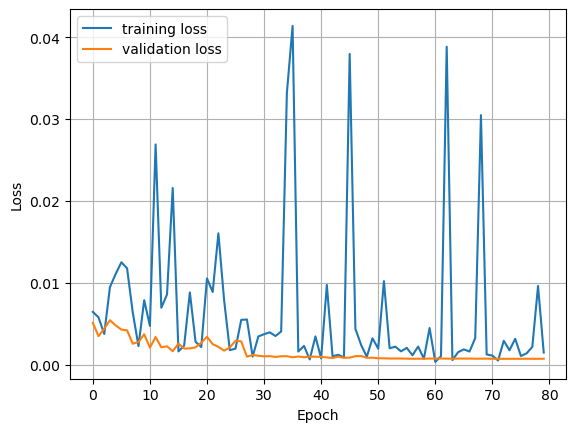

In [16]:
plt.plot(train_losses, label='training loss')
plt.plot(validation_losses, label='validation loss')
plt.legend();
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [18]:
# ModelCutter.load_state_dict(torch.load('Modele/Unet2_4in1out_MSELoss_Loss001_Enc_timm-resnest50d_80Epoch_0.pt'))
ModelCutter.eval()

Unet(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Save model

In [27]:
# Rename it !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# torch.save(ModelCutter.state_dict(), 'Modele/UN2-A_80E_MSEL.pt')

# Check model

In [19]:
inv_resize = transforms.Resize([480,640], interpolation=transforms.InterpolationMode.NEAREST)

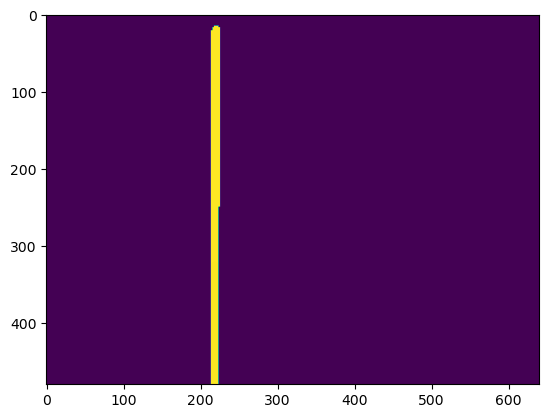

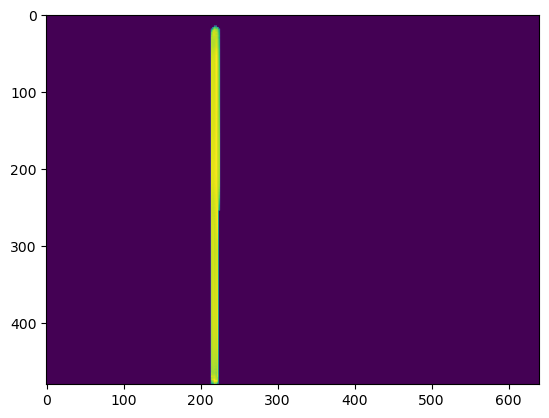

------------------------------------------------------------


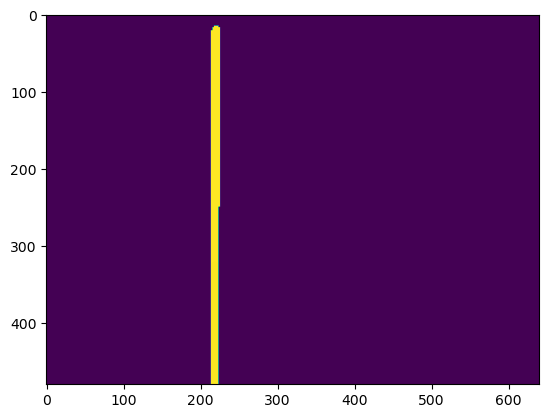

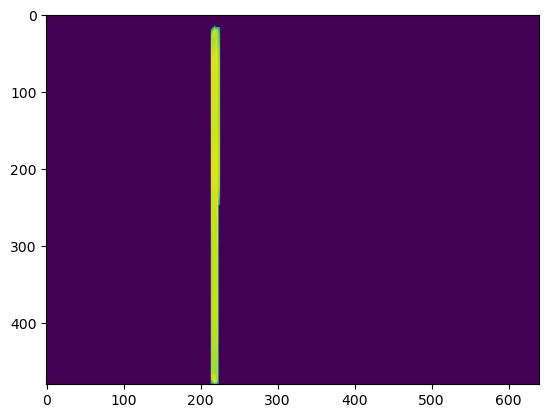

------------------------------------------------------------


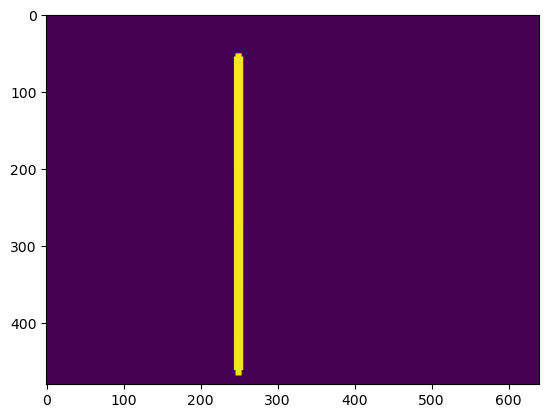

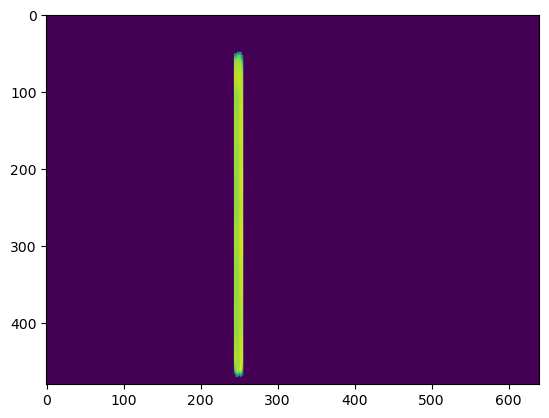

------------------------------------------------------------


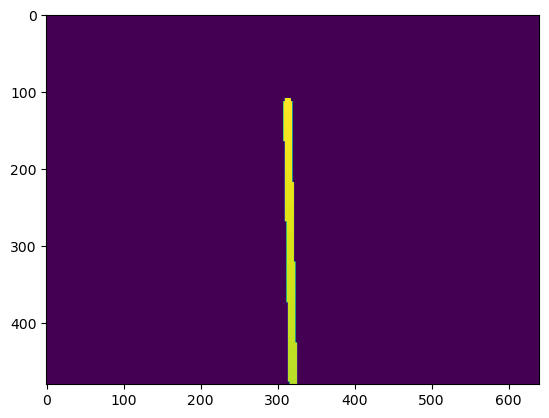

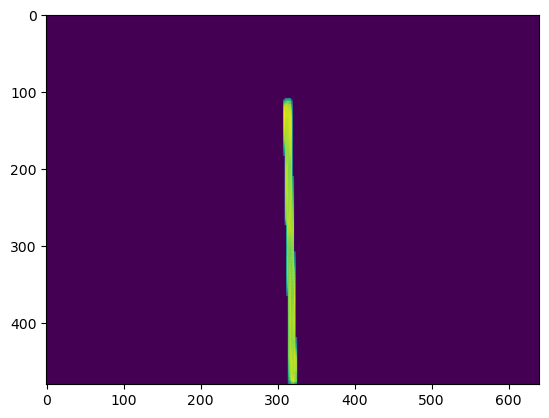

------------------------------------------------------------


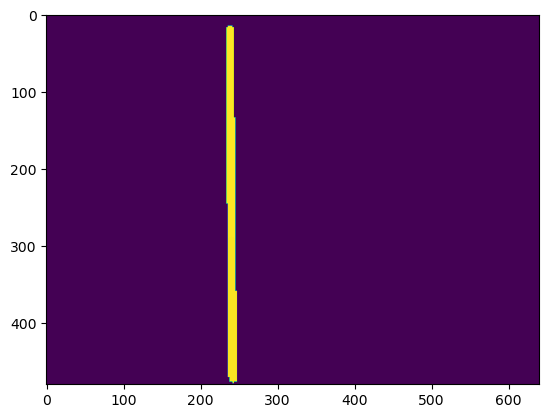

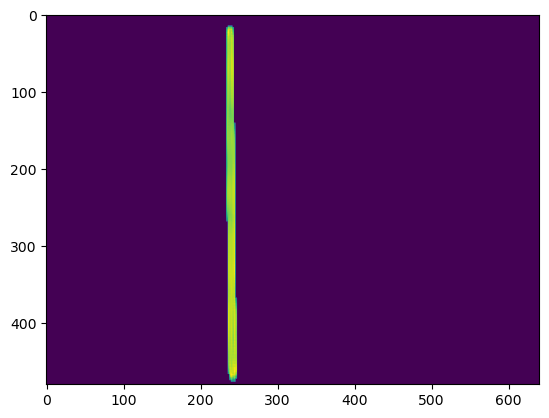

------------------------------------------------------------


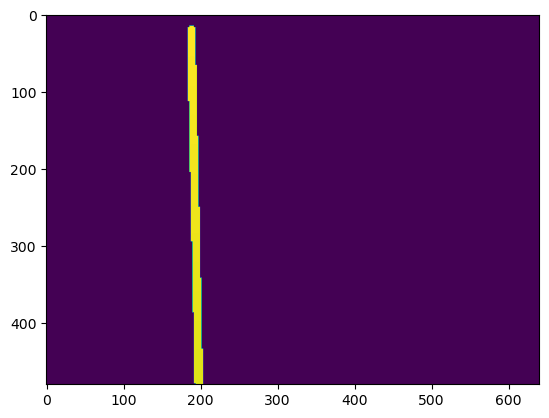

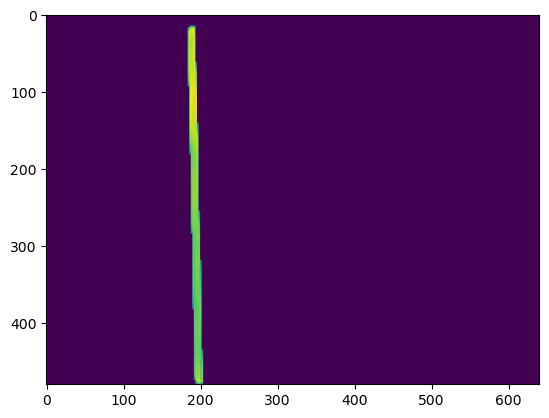

------------------------------------------------------------


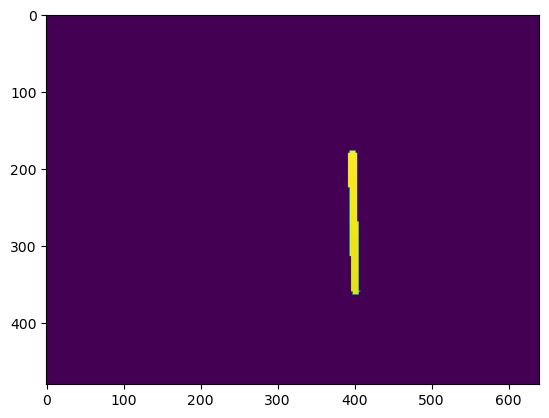

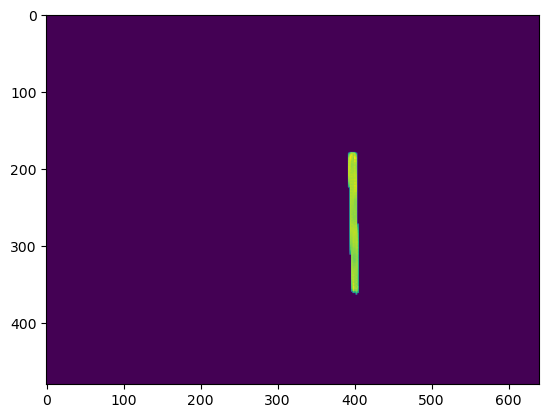

------------------------------------------------------------


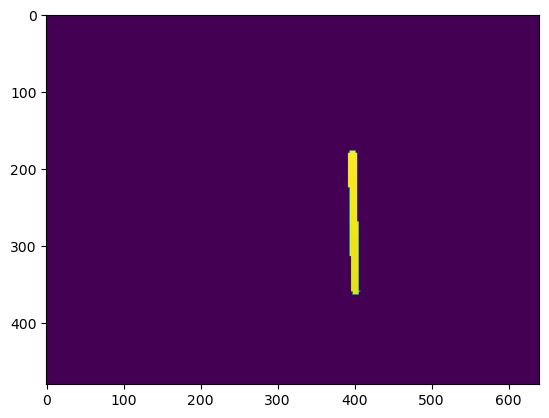

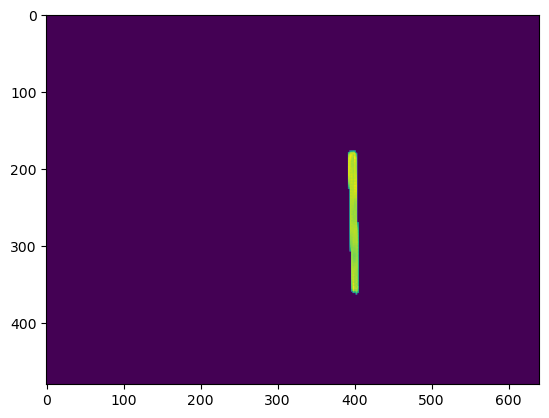

------------------------------------------------------------


KeyboardInterrupt: 

In [21]:
with torch.no_grad():
    for b, (images, true_mask) in enumerate(val_loader):
#         Apply the model
        images = images.to(device=device)
        true_mask = true_mask.to(device=device)
        
        seg_ax = Model(images)
        seg_ax = F.threshold(seg_ax, 0.2, 0)
        images_connected = torch.cat((images, seg_ax), axis=1)
#         images_connected = images_connected.reshape(images_connected.shape[0],
#                                                     4, 64, 80, 16) # transofrmation for UNet3D
#         true_mask = true_mask.reshape(true_mask.shape[0],
#                                                     1, 64, 80, 16) # transofrmation for UNet3D
        
        mask_pred = ModelCutter(images_connected)
        mask_pred = F.threshold(mask_pred, 1, 0)
        
        for j in range(mask_pred.shape[0]):
            images_buff = inv_resize(images[j])
            RGB_buff = images_buff[0].cpu().numpy()*255
#             print(RGB_buff.shape)
#             RGB_buff = np.transpose(RGB_buff, (1,2,0))
            RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

            DEPTH_buff = images_buff[1].cpu().numpy()*5500
            trueAxis_buff = inv_resize(true_mask[j].reshape(1,256,320)).cpu().detach().numpy().transpose(1,2,0)
            predAxis_buff = inv_resize(mask_pred[j].reshape(1,256,320)).cpu().detach().numpy().transpose(1,2,0)
            
#             NEW_DEPTH = DEPTH_buff.reshape(DEPTH_buff.shape[0],DEPTH_buff.shape[1],1)
#             new_axis = np.zeros([480,640,1])
#             new_axis[np.where(predAxis_buff > 1)] = NEW_DEPTH[np.where(predAxis_buff > 1)]
            
#             minval = np.min(new_axis[np.nonzero(new_axis)])
#             new_axis[np.where(predAxis_buff > 1)] = minval
            
            PC_object = CreatePointCloud(RGB_buff, DEPTH_buff)
            PC_realAxis = CreateAxisCloud(trueAxis_buff)
            PC_predAxis = CreateAxisCloud(predAxis_buff)
#             DrawnAxis = CreateAxisCloud(new_axis/1000)
            
            o3d.visualization.draw_geometries([PC_object, PC_predAxis])

            plt.figure()
            plt.imshow(trueAxis_buff)
    
#             plt.figure()
#             plt.imshow(seg_ax[j].cpu().detach().numpy().transpose(1,2,0))
#             plt.show()
            
            plt.figure()
            plt.imshow(predAxis_buff)
            plt.show()
            print('------------------------------------------------------------')

# Foty do pracy

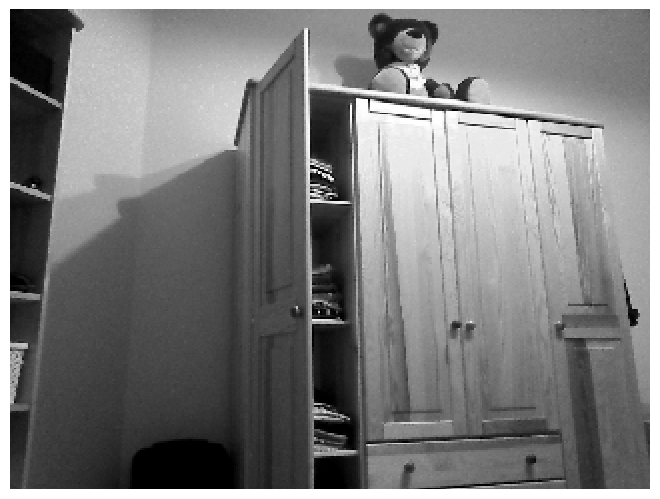

In [38]:
# aaa
Model.eval()
ModelCutter.eval()

num = 16
One_photo_x = X_validation[num].reshape(1,
                                      X_validation[num].shape[0],
                                      X_validation[num].shape[1],
                                      X_validation[num].shape[2]
                                     ).to(device)

One_photo_y = y_validation[num].reshape(1,
                                      y_validation[num].shape[0],
                                      y_validation[num].shape[1],
                                      y_validation[num].shape[2]
                                     ).to(device)

with torch.no_grad():
    seg2D = Model(One_photo_x)
    seg2D = F.threshold(seg2D, 1, 0)
    
    imag = torch.cat((One_photo_x, seg2D), axis=1)
    
    seg3D = ModelCutter(imag)
    seg3D = F.threshold(seg3D, 1, 0)

images_buff = inv_resize(One_photo_x[0])
RGB_buff = images_buff[0].cpu().numpy()*255
RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

DEPTH_buff = images_buff[1].cpu().numpy()*5500
trueAxis_buff = inv_resize(seg2D[0]).cpu().detach().numpy().transpose(1,2,0)
predAxis_buff = inv_resize(seg3D[0]).cpu().detach().numpy().transpose(1,2,0)

#             NEW_DEPTH = DEPTH_buffq

def SaveFig(input, path, cmap=None):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(input, aspect='auto',cmap=cmap)
    plt.show()
#     fig.savefig(path, format='png')

SaveFig(images_buff[0].cpu().numpy(), 'Images/gray1.png', cmap='gray')
# SaveFig(images_buff[1].cpu().numpy(), 'Images/dep1.png')
# SaveFig(images_buff[2].cpu().numpy(), 'Images/dep12.png')
# SaveFig(seg2D[0].cpu().detach().numpy().transpose(1,2,0), 'Images/seg1.png')
# SaveFig(seg3D[0].cpu().detach().numpy().transpose(1,2,0), 'Images/test_seg.npy')
# np.save('Images/test_seg.npy', seg3D[0].cpu().detach().numpy().transpose(1,2,0))

# RANSAC

In [3]:
from Libraries import RANSAC


regressor = RANSAC.RANSAC(model=RANSAC.LinearRegressor(), 
                          loss=RANSAC.square_error_loss, 
                          metric=RANSAC.mean_square_error, )

test = inv_resize(seg3D[0]).cpu().detach().numpy().transpose(1,2,0)
elo = test.flatten()
elo = elo[np.nonzero(elo)]

t = np.arange(elo.shape[0])
X = t.reshape(-1,1)
y = elo.reshape(-1,1)
regressor.fit(X, y)

import matplotlib.pyplot as plt
# plt.style.use("seaborn-darkgrid")
fig, ax = plt.subplots(1, 1)
ax.set_box_aspect(1)

plt.scatter(X, y)

line = np.linspace(0, X.shape[0], num=X.shape[0]).reshape(-1, 1)

# test_complete = test_complete[np.nonzero(test_complete)].flatten().reshape(-1, 1)
test[np.nonzero(test)] = regressor.predict(line).reshape(1, -1)

plt.plot(line, regressor.predict(line), c="r")

elo1 = test.flatten()
elo1 = elo1[np.nonzero(elo1)]

plt.figure()
t1 = np.arange(elo1.shape[0])
plt.scatter(t1, elo1)
plt.show()

plt.show()


IndentationError: unexpected indent (RANSAC.py, line 8)

In [40]:
PC_object = CreatePointCloud(RGB_buff, DEPTH_buff)
PC_predAxis = CreateAxisCloud(test)

o3d.visualization.draw_geometries([PC_object,PC_predAxis])